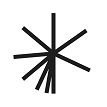

### Проект по спринту «Обучение с учителем: качество модели»: <br>прогноз\удержание активности пользователей интернет-магазина

<br><br>
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов.

#### Цели работы

Разработать решение, которое позволит <b>персонализировать предложения постоянным клиентам</b>, чтобы увеличить их покупательскую активность.


#### План работы

1. Предобработка данных<br>
2. Исследовательный анализ данных<br>
3. Сбор входных признаков<br>
4. Корелляционный анализ признаков
5. Подбор модели, предсказывающей снижение активности
6. Анализ важности признаков
7. Сегментирование покупателей и анализ выбранной группы
8. Выводы по проекту

### Загрузка данных

Загрузим все исходные данные, чтобы превратить их в датасеты для обучения. Перед этим сразу инициализируем все библиотеки, которые понадобятся нам в работе.

In [5]:
!pip install phik -q

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mtp
import seaborn as sns
import math
import phik
import time
import shap
from IPython.display import Image

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, \
MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score, f1_score

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

# importing models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [7]:
# constants

DATA_PATH = './datasets/' #provide the datasets path if differs
RANDOM_STATE = 2042 #a random number for data shuffle to be constant
TEST_SIZE = 0.25

In [8]:
# just some beauties

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   WHITE = '\033[30m' #not really white
   GREY = '\033[37m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
   B1 = '\033[100m' 
   B2 = '\033[101m'
   B3 = '\033[44m'
   B4 = '\033[41m'

# default chart font is quite ugly let's be honest
FONT = 'Calibri' #Tahoma
TITLE_FONT = 'Impact'

if FONT in(mtp.font_manager.get_font_names()):
    plt.rcParams.update({'font.family':FONT})
else:
    print(f'{color.B4}Не найден шрифт "{FONT}", для графиков будет использован дефолтный')

if TITLE_FONT not in(mtp.font_manager.get_font_names()):
    print(f'{color.B4}Не найден шрифт "{TITLE_FONT}", для заголовков графиков будет использован дефолтный')
    TITLE_FONT = 'DejaVu Sans'   

In [9]:
# switching off the warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
# some helpful tools made by me :)

# a function to unify the names of DF columns etc

def names_standartizer(names):    
    if type(names) == str:        
        names = names.strip().replace(' ', '_').lower()
    else:
        names = [item.strip().replace(' ', '_').replace(',', '').lower() for item in names]        
    return names

# a function to unify string (object) content in DF columns etc
# ⚠ !first check if columns of string (object) type REALLY contain strings (objects), otherwise they'll be corrupted

def string_cols_standartizer(df, cols_to_process=[], entire=False, auto=True):
    if auto:
        cols_to_process = df.select_dtypes(exclude='number').columns
    if not(entire):
        for col in cols_to_process: df[col] = names_standartizer(df[col])
    else:
        for col in df.columns:
            if df[col].dtype == object:
                df[col] = names_standartizer(df[col])
    return(df)
    

# showing all the basic info we'll need for data preprocessing

def df_info(data, unique_to_show=30):
    
    print('\033[107m'+'-⇓'*25+color.END, color.BOLD+color.BLUE+'STARTING THE INFO LIST OF DATAFRAME'
          +color.END, '\033[107m'+'⇓-'*10 + color.END)
    display(data[:7])
    display(data.info()) 
    print('⚠ Количество полных дубликатов по строкам:', data.duplicated().sum())

    for col in data.columns:        
        print('\n', '\n\033[103m'+"--~"*8+color.END, 'INFO OF COLUMN '+color.BOLD+color.DARKCYAN+col+color.END, "~--"*(round((50-len(col))/3)), '\n')
        print('✅ '+color.UNDERLINE+'Общая доступная стат. информация:'+color.END)
        print(data[col].describe())
        print("\n✅"+color.UNDERLINE+"Количество пропущенных значений"+color.END+" =", data[col].isna().sum())
        print("\n✅ "+color.UNDERLINE+"Количество уникальных значений"+color.END+" =", data[col].nunique())
        if data[col].nunique() < unique_to_show:
            print("Уникальные значения: \n", data[col].unique())
        else:
            print("Первые", unique_to_show, "уникальных значений: \n", data[col].unique()[:unique_to_show])
        print('\033[103m'+"-"*90+color.END)
    print('\n\033[107m'+"-⇑"*25+color.END, color.BOLD+color.BLUE+'THE END OF INFO LIST OF DATAFRAME'
          +color.END, '\033[107m'+ "⇑-"*10 + color.END, '\n')

In [11]:
# HEY! HO! LET'S GO!

# datasets loading

try:
    cust_activity = pd.read_csv(DATA_PATH + 'market_file.csv')
    cust_money = pd.read_csv(DATA_PATH + 'market_money.csv')
    cust_time = pd.read_csv(DATA_PATH + 'market_time.csv')
    sell_income = pd.read_csv(DATA_PATH + 'money.csv', sep=';')
except:
    print('Ошибка в загрузке датасетов! Проверьте, пожалуйста, каталог, где должны лежать данные:', DATA_PATH)

In [12]:
# making names for our datasets

cust_activity.name = 'cust_activity'
cust_money.name = 'cust_money'
sell_income.name = 'sell_income'
cust_time.name = 'cust_time'

### Предобработка данных

#### Предварительный анализ данных

Для начала приведём названия столбцов в датасетах к принятым стандартам.

In [16]:
# creating a list of all datasets. we'll need this!
datasets_ls = [cust_activity, cust_money, cust_time, sell_income]

# simply standardizing all the columns in all datasets in the cycle
for df in datasets_ls:
    df.columns = names_standartizer(df.columns)

Теперь обработаем столбцы с категориальными переменными, отправив датасеты и соответствующие колонки в наш стандартизатор <code>string_cols_standartizer</code> (сокр. от String Columns Standartizer).<br>
Предварительно убедимся, что в колонках, обозначенных как строковые, действительно содержатся строки - иначе обработка пройдёт некорректно.

In [18]:
for f in datasets_ls:
    display(f[:4])
    f.info()
    print('\n')

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB




,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB




,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB




Бинго! В датасете <code>sell_income</code> столбец "Прибыль" объявлен строковым, хотя содержит числа. Разберёмся с этим позднее, на этапе корректировки типов данных, а сейчас просто не будем отправлять такие "строки" на стандартизацию (тем более, что строк в датасете <code>sell_income</code> не содержится вообще).

In [20]:
for f in datasets_ls[:3]:
    try:
        f = string_cols_standartizer(f)
        print(f'Строки в датасете {f.name} обработаны успешно!')
    except:
        print(f'Ошибка при обработке строк в датасете {f.name}')

Строки в датасете cust_activity обработаны успешно!
Строки в датасете cust_money обработаны успешно!
Строки в датасете cust_time обработаны успешно!


Используя кастомную функцию <code>df_info</code>, детально осмотрим содержимое каждого датасета и выпишем, какие данные нуждаются в корректировке типов, а какие - в корректировке значений.<br><br>
Этот код в финальной версии проекта будет закомментирован, поскольку вывод информации по всем датасетам занимает очень много места (примерно 20 экранов). Для проверки корректности сделанных выводов можно раскомментировать код.

In [22]:
# for f in datasets_ls: df_info(f)

#### Итоги предварительные анализа

- Датасет <b>cust_activity</b>.<br>
В колонке <code>тип_сервиса</code> содержатся дублирующие друг друга значения: 'стандартт' и 'стандарт'. Исправим некорректное написание.<br>
В строковой колонке <code>разрешить_сообщать</code> содержатся, по сути, булевые значения "да" и "нет". Лучше изменим тип - это существенно сократит размер колонки.<br>
В колонке <code>популярная_категория</code> одно из значений содержит ошибку: 'косметика_и_аксесуары'. Хорошо, что мы - дата-сайентисты 
со знанием не только питоньего, но и русского языка. Исправим.
<br>
Колонки <code>средний_просмотр_категорий_за_визит, неоплаченные_продукты_штук_квартал, ошибка_сервиса, страниц_за_визит</code> могут содержать только целые числа. Изменим тип с вещественного.
<br><br>
- Датасет <b>cust_money</b>.<br>
Для этого этапа исследования с данными <i>с оговорками</i> всё в порядке. Прилагательное "препредыдущий" звучит не слишком грамотно, ну да ладно. Ещё отметим, что здесь тоже можно было бы заменить три категории времени на цифры.<br><br>
- Датасет <b>cust_time</b>.<br>
В колонке <code>период</code> содержится опечатка в названии категории "предыдцщий_месяц". Обязательно исправим.<br><br>
- Как отмечено ранее, в датасете <b>sell_income</b> столбец "Прибыль" строковый. Изменим на тип float. 


#### Внесение необходимых исправлений в данные

Исправим обнаруженные выше недостатки несложным кодом. Также определим, насколько удалось оптимизировать размер датасетов.

In [26]:
memory_before = 0
for f in datasets_ls:
    memory_before += f.memory_usage().sum()/1024

In [27]:
cust_activity['тип_сервиса'] = cust_activity['тип_сервиса'].replace('стандартт', 'стандарт')
cust_activity['популярная_категория'] = cust_activity['популярная_категория'].replace('косметика_и_аксесуары', 'косметика_и_аксесcуары')

cust_activity['разрешить_сообщать'] = cust_activity['разрешить_сообщать'].apply(lambda x: 0 if x == 'нет' else 1).astype('int8')

cats_to_int = ['средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']
cust_activity[cats_to_int] = cust_activity[cats_to_int].astype('int32')

cust_time['период'] = cust_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

In [28]:
sell_income['прибыль'] = sell_income['прибыль'].str.replace(',', '.').astype('float32')

#### Результаты оптимизации размера датасета

In [30]:
memory_after = 0
for f in datasets_ls:
    memory_after += f.memory_usage().sum()/1024

print(f'Сократили размер датасетов на {memory_before-memory_after:.2f} килобайт, или на {(memory_before-memory_after)/memory_before:.2%}')

Сократили размер датасетов на 34.28 килобайт, или на 11.23%


>Изменив типы некоторых исходных данных на более подходящие, мы уменьшили общий размер, занимаемый всеми датасетами в памяти, на 11%. Хороший результат!

In [32]:
for f in datasets_ls:
    print('Дубликатов:', f.duplicated().sum())
    print(f.isna().sum(), '\n')

Дубликатов: 0
id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64 

Дубликатов: 0
id         0
период     0
выручка    0
dtype: int64 

Дубликатов: 0
id        0
период    0
минут     0
dtype: int64 

Дубликатов: 0
id         0
прибыль    0
dtype: int64 



>В исходных данных не обнаружено ни дубликатов, ни пропусков.

### Исследовательский анализ данных

#### Выбросы/аномальные значения

Для быстрого определения выбросов и аномалий удобно построить гистограммы параметров (показателей из датасетов).

Гистограммы параметров в датасете cust_activity: 



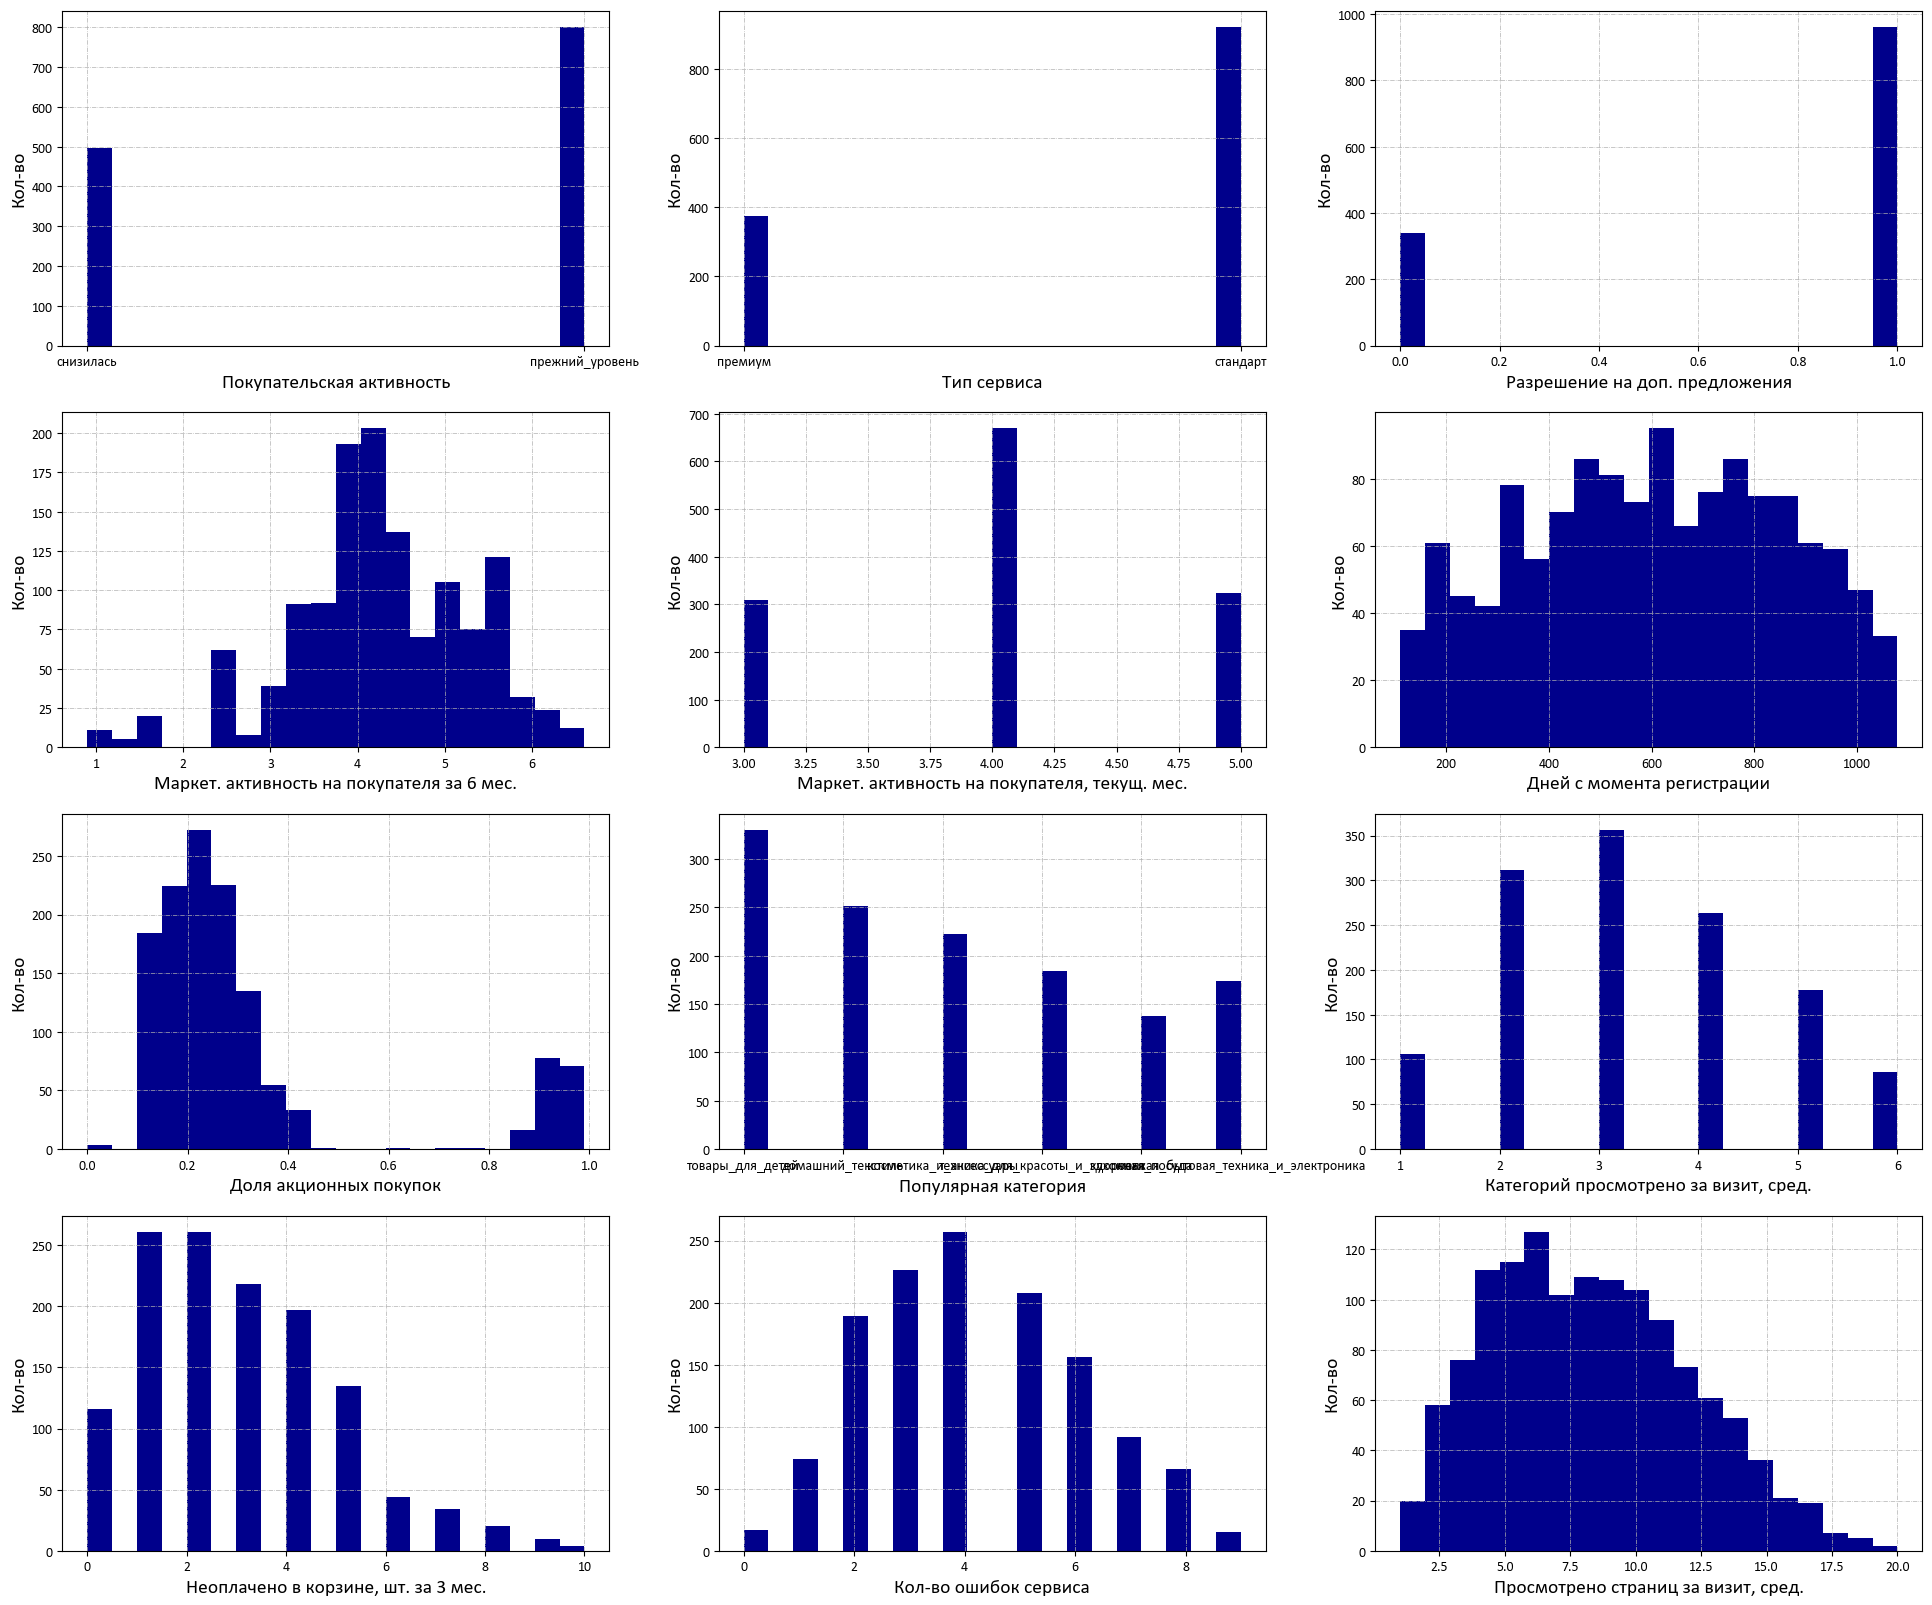

In [37]:
print(color.BOLD+'Гистограммы параметров в датасете cust_activity: \n')

col_to_drop = 'id' # columns we do not need to draw
cols = cust_activity.drop(col_to_drop, axis=1).columns # list of columns to draw
col_num = len(cols)

# MANUALLY set the number of histogram columns 'hcol'. rows num 'hrow' will be calculated 
hcol = 3
hrow = math.ceil(col_num/hcol)

fig, axs = plt.subplots(hrow, hcol, figsize=(hcol*8, hrow*5))

# we need a separate list for hist. captions, it looks better than using just column's names
xcaptions = ['Покупательская активность', 'Тип сервиса', 'Разрешение на доп. предложения', 'Маркет. активность на покупателя за 6 мес.',
 'Маркет. активность на покупателя, текущ. мес.', 'Дней с момента регистрации', 'Доля акционных покупок',
 'Популярная категория', 'Категорий просмотрено за визит, сред.', 'Неоплачено в корзине, шт. за 3 мес.',
 'Кол-во ошибок сервиса', 'Просмотрено страниц за визит, сред.']

for i in range (hrow):
    for feat in range(0, hcol):
        feat_1d = feat+hcol*i   # transforming 2d-"coordinates" to linear ordinal num of feature in columns list
        if feat_1d < col_num:    # num of features could be less than determined grid of 'hrow' x 'hcol', this'll cause an error
            axs[i][feat].hist(cust_activity[cols[feat_1d]], bins=20, color='DarkBlue')
            axs[i][feat].set_xlabel(xcaptions[feat_1d], fontsize=14)
            axs[i][feat].set_ylabel('Кол-во', fontsize=14)
            axs[i][feat].grid(axis='both', linestyle='dashdot', linewidth=0.5)
plt.show()

> Выбросов и аномалий в датасете с основными активностями пользователя не обнаружено

В оставшихся датасетах всего три количественных параметра. Мы выведем их в одном графике в виде диаграмм размаха - на них тоже легко заметить "выдающиеся" значения.

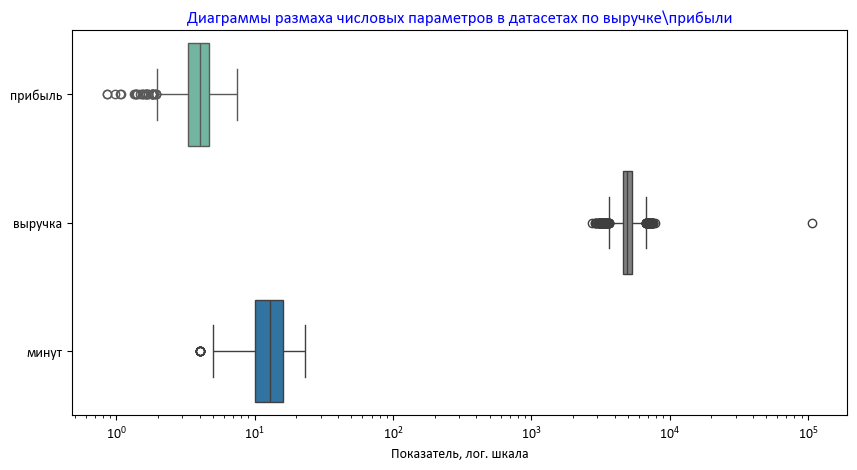

In [40]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(sell_income.drop('id', axis=1), log_scale=True, orient='h', palette='Set2')
sns.boxplot(cust_money.drop('id', axis=1), orient='h', color='Gray')
sns.boxplot(cust_time.drop('id', axis=1), orient='h')
ax.set_title('Диаграммы размаха числовых параметров в датасетах по выручке\прибыли', fontsize=12, color='blue')
ax.set_xlabel('Показатель, лог. шкала')
plt.show()

>В показателях выручки заметно аномально выделяющееся значение. С этим следует разобраться.<br>
Также обращают на себя внимание крайне небольшие показатели прибыли для магазина от продавцов (первый "ящик с усами" на графике). Очень похоже, что значения приведены здесь в тысячах единиц валюты. 

Проведём небольшое расследование. Не обязательно столь большое значение прибыли ошибочно - но оно помешает обучить нам модель качественно, поскольку сильно выбивается из прочих. <br>
Такие затраты понёс клиент с id = 215380, точная сумма равна 106862.2, и это данные за текущий месяц.<br>
Его траты за более ранние периоды:
- прошлый месяц 6077.0
- позапрошлый месяц 5051.0<br>

Популярная категория - техника для красоты и здоровья, почти всё куплено по акциям.<br>
Возможно, покупателю весьма неплохо повезло в лотерею, или же он решил пуститься во все тяжкие по иным причинам. Важно то, что сумма, более чем на порядок превышающая средние траты других клиентов, внесёт существенную ошибку в наши модели. Можно её убрать, но ещё лучше заменить на среднее, чтобы в наших данных не образовывалась дырка, которая способна вызвать проблемы при объединении данных.<br>
Среднее за месяцы до аномалии у клиента (6077 + 5051)/2 = 5564. Запишем в датасет это число и проверим.

In [43]:
row_anomaly = int(np.where(cust_money['выручка'] == cust_money['выручка'].max())[0])
id_rich = int(cust_money['id'].iloc[row_anomaly])

# calculating mean of pre- & prepre-month
mean_before_getting_rich = cust_money.query('id == @id_rich and index != @row_anomaly')['выручка'].mean()

# finding location of max income and rewriting it
cust_money['выручка'].iloc[row_anomaly] = mean_before_getting_rich

#OOK it's really ugly solution, will be thankful for more neat code lol )

Ниже - исправленная выручка от "богатого" клиента. Всё в порядке, аномальное значение изменилось на среднее от двух прочих.

In [45]:
cust_money.loc[cust_money['id'] == 215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,5564.0


Выведем актуальный топ по выручкам. Гигантских выдающихся значений теперь не наблюдается.<br>
Аномалия побеждена!

In [47]:
cust_money.sort_values(by='выручка', ascending=False)[:3]

,id,период,выручка
435,215493,текущий_месяц,7799.4
262,215435,текущий_месяц,7605.3
1481,215841,текущий_месяц,7557.0


Переведём прибыль магазина по каждому отдельному покупателю из тысяч в единицы валюты.

In [49]:
sell_income['прибыль'] = round(sell_income['прибыль']*(1000), 2)
sell_income[:4]

,id,прибыль
0,215348,980.0
1,215349,4160.0
2,215350,3130.0
3,215351,4870.0


Так больше похоже на правду! На этом исследовательский анализ завершён.

#### Итоги исследовательского анализа

В процессе Exploratory data analysis (исследовательский анализ данных) мы избавились от аномалий в данных и удостоверились в том, что все параметры представлены в одинаковых единицах измерения.

### Объединение данных

При обучении моделей наиболее удобно иметь все данные в одной таблице (датасете). У нас же их четыре. Займёмся объединением!
<br>
<b>N.B.</b> Данные о прибыли с каждого конкретного покупателя <code>sell_income</code> при моделировании нам не понадобятся.

Сперва состыкуем датасеты со временем <code>cust_time</code> и тратами пользователя <code>cust_money</code>. Они имеют формы (2600, 3) и (3900, 3). При этом всего уникальных id пользователей там 1300, то есть в первом есть данные по каждому юзеру в двух временных периодах, а втором - данные в трёх периодах (позапрошлый, прошлый, текущий месяцы). При объединении мы должны получить датафрейм размерностью (3900, 4), и получить ровно 1300 значений NaN - ведь для первого ДС нет данных о позапрошлом месяце.

In [56]:
cust_time.shape, cust_money.shape

((2600, 3), (3900, 3))

In [57]:
cust_mt = cust_money.merge(cust_time, how='left')
display(cust_mt.shape)
display(cust_mt.isna().sum())
display(cust_mt[:6])

(3900, 4)

id            0
период        0
выручка       0
минут      1300
dtype: int64

,id,период,выручка,минут
0,215348,препредыдущий_месяц,0.0,NaN
1,215348,текущий_месяц,3293.1,14.0
2,215348,предыдущий_месяц,0.0,13.0
3,215349,препредыдущий_месяц,4472.0,NaN
4,215349,текущий_месяц,4971.6,10.0
5,215349,предыдущий_месяц,5216.0,12.0


Видим, что объединение прошло успешно.

Теперь более сложная задача. Для обучения модели нам желательно иметь данные по конкретному юзеру в отдельной строке - а не в трёх, как сейчас. Чтобы комбинации период-выручка, период-время были отдельными фичами. Реализуем этот "переворот" в коде.<br>
<b>N.B.</b> Схема названий новых столбцов на примере <code>мин1_мес_доход</code>: доход за -1 месяц от текущего, т. е. за прошлый месяц.

In [60]:
ids = cust_time['id'].unique()
cols = ['id', 'мин2_мес_доход', 'мин1_мес_доход', 'тек_мес_доход', 'мин2_мес_время', 'мин1_мес_время', 'тек_мес_время']
#could use 'unique()' here too, but I don't like the order, it goes -2, current, -1
# instead of desirable -2, -1, current
period = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']
param = ['выручка', 'минут']
cust_mt_transformed = pd.DataFrame(columns=cols)

for cust_id in ids:
    forming_row = cust_id
    for prm in param:
        for per in period:
            forming_row = np.append(forming_row, (cust_mt.loc[cust_mt['id']==cust_id].loc[cust_mt['период']==per][prm]))
    cust_mt_transformed.loc[len(cust_mt_transformed)] = forming_row

Справились ли мы с этим вызовом? Проверяем форму, отсутствующие значения и сами показатели, сравнивая их с объединённым временным датасетом <code>cust_mt</code>.

In [62]:
display(cust_mt_transformed.shape)
display(cust_mt_transformed.isna().sum())
display(cust_mt_transformed)

(1300, 7)

id                   0
мин2_мес_доход       0
мин1_мес_доход       0
тек_мес_доход        0
мин2_мес_время    1300
мин1_мес_время       0
тек_мес_время        0
dtype: int64

,id,мин2_мес_доход,мин1_мес_доход,тек_мес_доход,мин2_мес_время,мин1_мес_время,тек_мес_время
0,215348.0,0.0,0.0,3293.1,NaN,13.0,14.0
1,215349.0,4472.0,5216.0,4971.6,NaN,12.0,10.0
2,215350.0,4826.0,5457.5,5058.4,NaN,8.0,13.0
3,215351.0,4793.0,6158.0,6610.4,NaN,11.0,13.0
4,215352.0,4594.0,5807.5,5872.5,NaN,8.0,11.0
...,...,...,...,...,...,...,...
1295,216643.0,4704.0,3664.0,4741.7,NaN,14.0,7.0
1296,216644.0,5299.0,4729.0,5353.0,NaN,12.0,11.0
1297,216645.0,5334.0,5160.0,5139.2,NaN,12.0,18.0
1298,216646.0,4725.0,4923.0,5224.6,NaN,18.0,7.0


Отлично! Только уберём столбец min_2mon_time - данных по времени, проведенному юзером на сайте в позапрошлом месяце, у нас нет.

In [64]:
cust_mt_transformed = cust_mt_transformed.drop('мин2_мес_время', axis=1)

In [65]:
# some cleansing here

del(cust_mt)

Продолжаем работать над объединением. Осталось внести трансформированные данные в "основной" датасет - тот, который содержит наибольшее количество параметров - <code>cust_activity</code>

In [67]:
cust_full = cust_activity.merge(cust_mt_transformed, on='id')

Проверяем, как всё прошло - должно добавиться 5 новых параметров, данных NaN быть не должно, столбцы\строки не должны съехать или перепутаться.

In [69]:
print('Размерность датасета cust_activity:', cust_activity.shape)
print('Размерность полного датасета cust_full:', cust_full.shape)

Размерность датасета cust_activity: (1300, 13)
Размерность полного датасета cust_full: (1300, 18)


In [70]:
cust_full.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
мин2_мес_доход                         0
мин1_мес_доход                         0
тек_мес_доход                          0
мин1_мес_время                         0
тек_мес_время                          0
dtype: int64

#### Полный объединённый датасет

Выборочно проверяем несколько id, чтобы окончательно убедиться в успешности операции объединения.

In [73]:
cust_full

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,мин2_мес_доход,мин1_мес_доход,тек_мес_доход,мин1_мес_время,тек_мес_время
0,215348,снизилась,премиум,1,3.4,5,121,0.00,товары_для_детей,6,2,1,5,0.0,0.0,3293.1,13.0,14.0
1,215349,снизилась,премиум,1,4.4,4,819,0.75,товары_для_детей,4,4,2,5,4472.0,5216.0,4971.6,12.0,10.0
2,215350,снизилась,стандарт,0,4.9,3,539,0.14,домашний_текстиль,5,2,1,5,4826.0,5457.5,5058.4,8.0,13.0
3,215351,снизилась,стандарт,1,3.2,5,896,0.99,товары_для_детей,5,0,6,4,4793.0,6158.0,6610.4,11.0,13.0
4,215352,снизилась,стандарт,0,5.1,3,1064,0.94,товары_для_детей,3,2,3,2,4594.0,5807.5,5872.5,8.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295,216643,прежний_уровень,стандарт,1,6.6,3,318,0.24,техника_для_красоты_и_здоровья,5,3,3,11,4704.0,3664.0,4741.7,14.0,7.0
1296,216644,прежний_уровень,стандарт,0,5.1,4,454,0.21,домашний_текстиль,6,2,3,9,5299.0,4729.0,5353.0,12.0,11.0
1297,216645,прежний_уровень,стандарт,1,4.1,3,586,0.20,домашний_текстиль,3,2,5,7,5334.0,5160.0,5139.2,12.0,18.0
1298,216646,прежний_уровень,стандарт,1,6.3,5,645,0.12,техника_для_красоты_и_здоровья,3,3,5,7,4725.0,4923.0,5224.6,18.0,7.0


><b>Итоги:</b> <i>мы успешно объединили все датасеты в одну таблицу.</i>

In [75]:
# simple "(col1) and (col2) and (col3)" will show if any of those cols is 0
mask_is_active = np.logical_and.reduce(cust_full[['мин2_мес_доход', 'мин1_мес_доход', 'тек_мес_доход']].astype(bool), axis=1)

# then deleting rows by that mask
cust_full = cust_full.drop(cust_full[~mask_is_active].index, axis=0)

In [76]:
print('Удалили малоактивных клиентов (нет покупок хотя бы в 1 месяце). Проверка размерности:')
cust_full.shape

Удалили малоактивных клиентов (нет покупок хотя бы в 1 месяце). Проверка размерности:


(1297, 18)

### Корреляционный анализ


Этот вид анализа необходим, чтобы:
- исключить признаки, линейно зависящие друг от друга,
- избежать "утечки" признаков,
- в общем оценить зависимости таргета от фичей, при необходимости ввести новые фичи для нелинейных зависимостей.

Рассчитаем корреляцию между числовыми признаками, а затем построим тепловую карту. Для наглядности отобразим на ней только зависимости сильнее <b>умеренной</b> прямо пропорциональной связи (коэффициент 0.3–0.5 по шкале Чеддока).

In [80]:
corr_matrix = cust_full.drop('id', axis=1).corr(method='spearman', numeric_only=True)
corr_matrix = corr_matrix[(corr_matrix>0.3)|(corr_matrix<-0.3)]

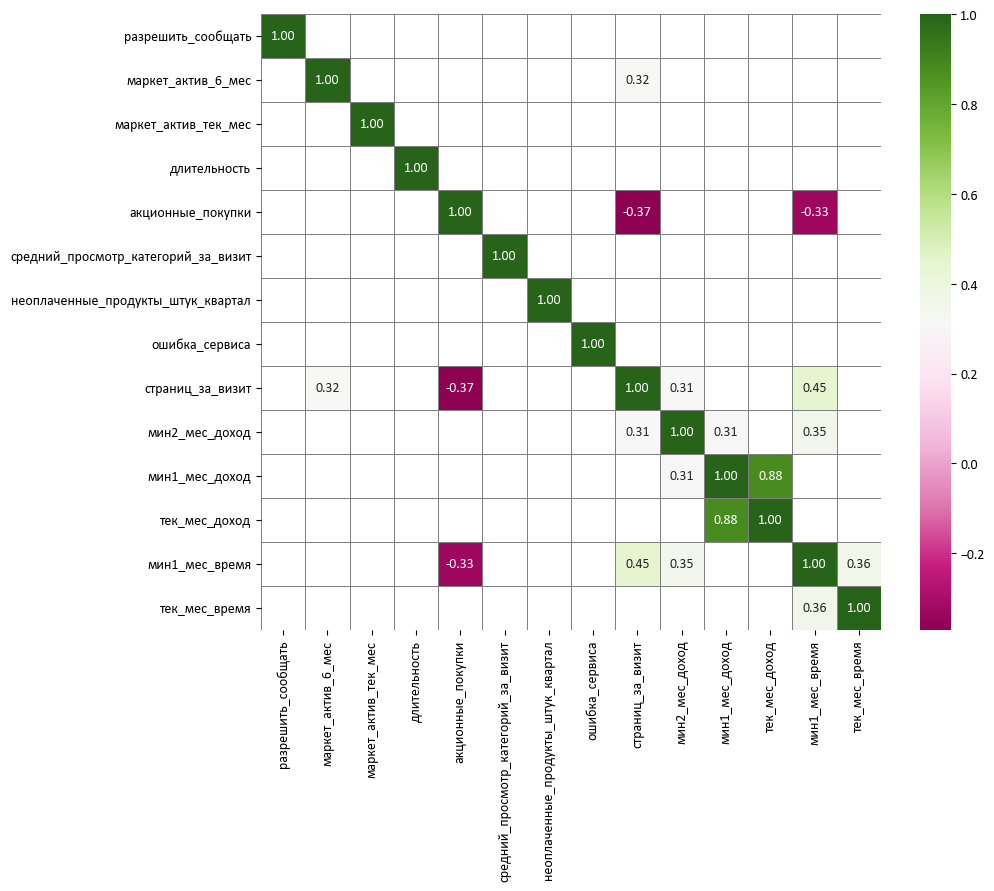

In [81]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='PiYG', linewidths=0.5, linecolor='grey');

Видим только довольно сильную связь между суммой, потраченной пользователем в текущем месяце, с суммой за предыдущий месяц. Возможна мультиколлинеарность! "Возможна" - потому что o наличии существенной частичной мультиколлинеарности в модели говорят большие по абсолютной величине (больше 0,9) коэффициенты корреляции. А у нас значения чуть ниже.
<br>Позже определимся, удалять ли один из этих признаков.

Теперь изучим взаимосвязи признаков с целевой переменной <code>Покупательская активность</code>.

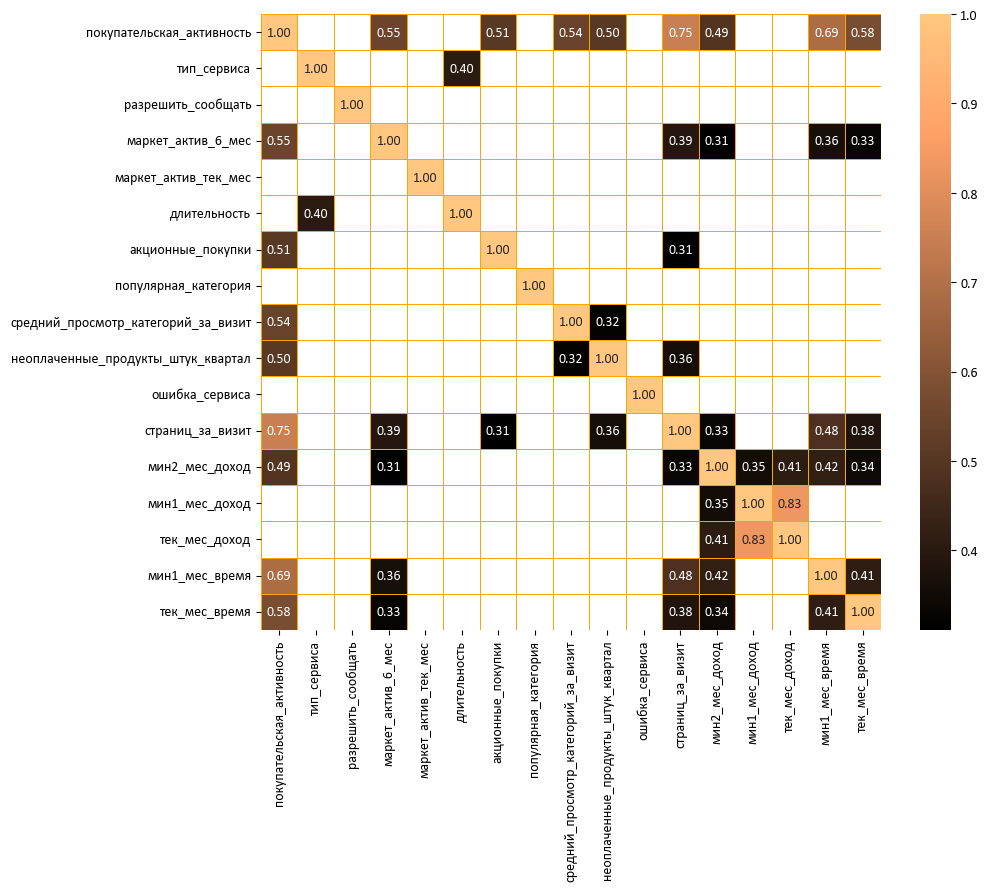

In [84]:
interval_cols = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 
                 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
                 'страниц_за_визит', 'мин2_мес_доход', 'мин1_мес_доход', 'тек_мес_доход', 'мин1_мес_время', 'тек_мес_время']
corr_matrix = cust_full.drop('id', axis=1).phik_matrix(interval_cols = interval_cols)
corr_matrix = corr_matrix[(corr_matrix>0.3)|(corr_matrix<-0.3)]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='copper', linewidths=0.5, linecolor='orange');

Видим довольно высокую связь между целевой переменной и признаком <code>страниц_за_визит</code> - это среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца. Вот здесь возможна утечка! Очень маленький показатель <code>страниц_за_визит</code> прямо говорит о том, что активность юзера снизилась, и с какого-то порога модель может ориентироваться в предсказании только на него.

#### Распределения параметров у групп разной активности

Посмотрим на параметры у пользователей со снизившейся активностью и с прежней.

In [88]:
a = cust_full[cust_full['покупательская_активность']=='прежний_уровень']['популярная_категория'].count()
b = cust_full[cust_full['покупательская_активность']=='снизилась']['популярная_категория'].count()
goods_same_act = cust_full[cust_full['покупательская_активность']=='прежний_уровень']['популярная_категория'].value_counts()*100/a
goods_lower_act = cust_full[cust_full['покупательская_активность']=='снизилась']['популярная_категория'].value_counts()*100/b
goods_s = pd.DataFrame(goods_same_act.reset_index()).rename(columns={'count':'same_act'})
goods_l = pd.DataFrame(goods_lower_act.reset_index()).rename(columns={'count':'lower_act'})
goods = goods_s.merge(goods_l)
display(round(goods).sort_values(by='lower_act'))

,популярная_категория,same_act,lower_act
2,мелкая_бытовая_техника_и_электроника,18.0,5.0
3,техника_для_красоты_и_здоровья,16.0,10.0
5,кухонная_посуда,9.0,13.0
1,домашний_текстиль,19.0,20.0
4,косметика_и_аксесcуары,15.0,21.0
0,товары_для_детей,23.0,29.0


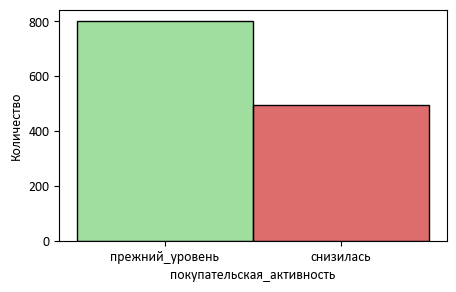

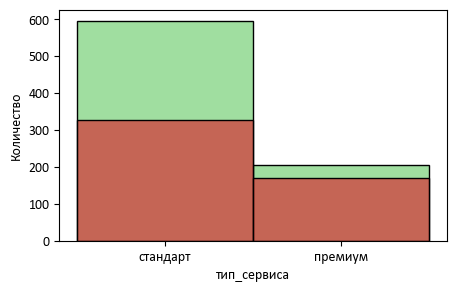

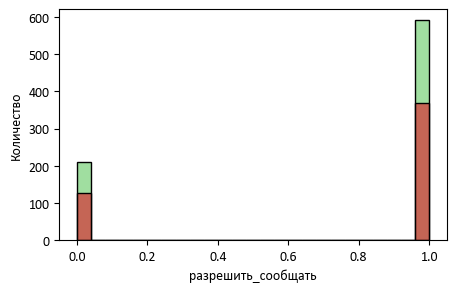

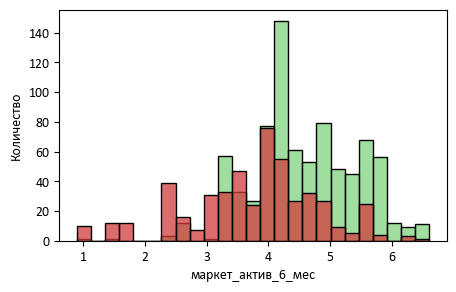

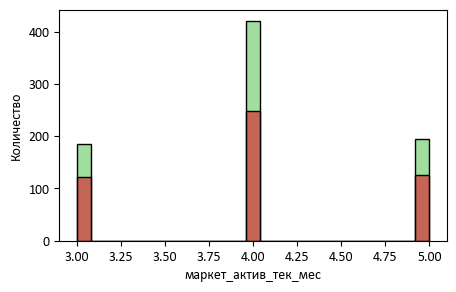

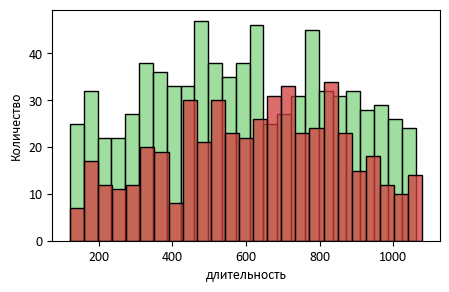

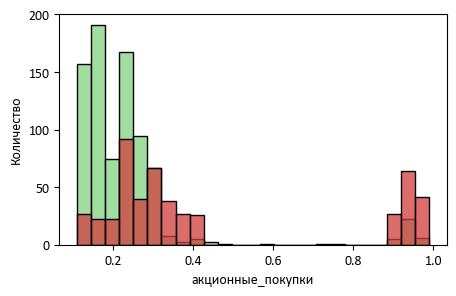

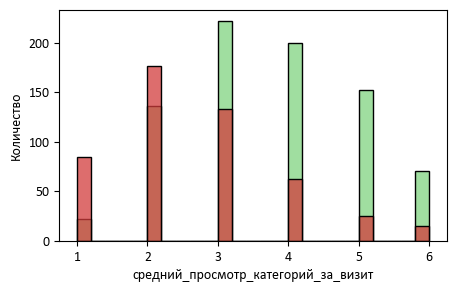

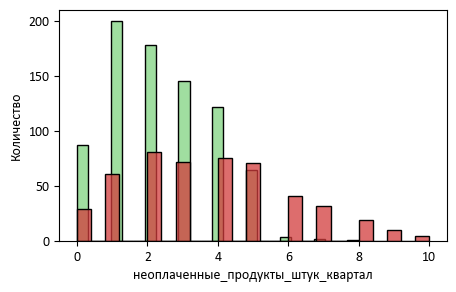

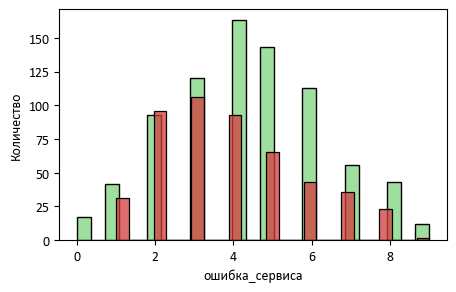

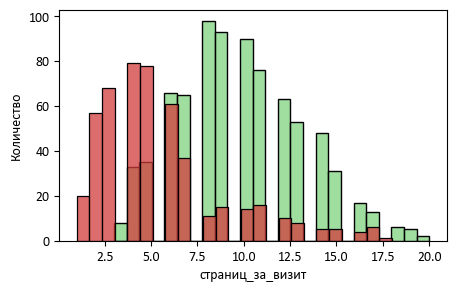

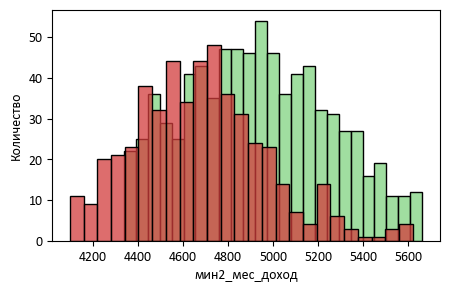

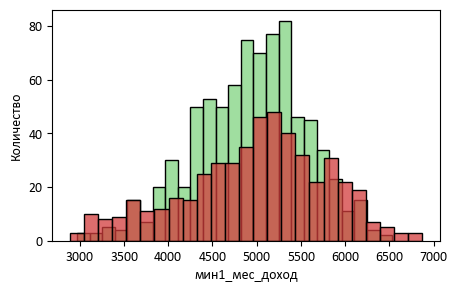

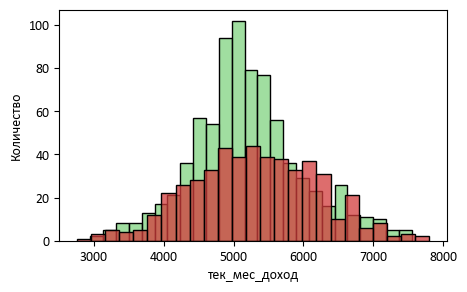

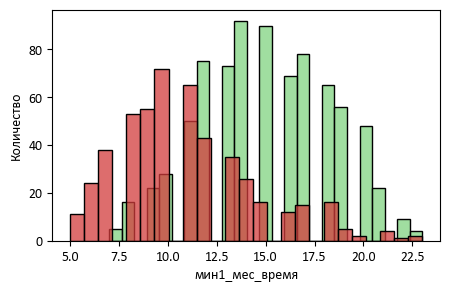

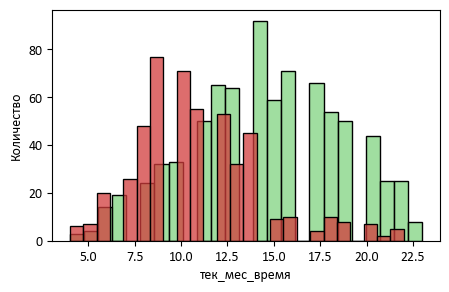

In [89]:
for col in cust_full.drop(['id', 'популярная_категория'], axis=1):
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.histplot(cust_full[cust_full['покупательская_активность']=='прежний_уровень'][col], bins=25, color='#81D481');
    sns.histplot(cust_full[cust_full['покупательская_активность']=='снизилась'][col], bins=25, color='#D23C3C');
    ax.set(ylabel = "Количество")
    plt.show()

<b>Отличия снизивших активность пользователей от "стабильной" части пользователей:</b>
- большее количество высокой доли акционных покупок,
- больше просматривают 1-2 категории за визит,
- от 6 неоплаченных продуктов за квартал: почти все такие клиенты - "сниженные" юзеры,
- существенное уменьшение доли страниц за визит, начиная примерно с показателя в 7,5 стр/визит, 
когда у "стабильных" юзеров здесь находится мода (наиболее частое значение),
- меньше среднее время за прошлый и текущий месяцы.

Доли категорий товаров для "стабильных" покупателей:
1) товары_для_детей - 23%,
2) домашний_текстиль - 19%,
3) мелкая_бытовая_техника_и_электроника - 18%,
4) техника_для_красоты_и_здоровья - 16%.

Доли категорий товаров для покупателей со снизившейся активностью:
1) товары_для_детей - 29%,
2) косметика_и_аксесcуары - 21%,
3) домашний_текстиль - 20%,
4) кухонная_посуда - 13%,
5) техника_для_красоты_и_здоровья - 16%.

### Подбор моделей и гиперпараметров с помощью пайплайнов

#### Разбиение датасетов и проверка на дисбаланс классов

Выделим тренировочную и тестовую выборки, определим категориальные и числовые параметры.

In [94]:
X = cust_full.drop(['id','покупательская_активность', 'тек_мес_доход'], axis=1)
y = cust_full['покупательская_активность']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = cust_full['покупательская_активность'])

print(color.BOLD+'Размерность тренировочной выборки:' +color.END, X_train.shape)
print(color.BOLD+'Размерность тестовой выборки:' +color.END, X_test.shape)
print(color.BOLD+color.BLUE+'Размерность тренировочного таргета:' +color.END, y_train.shape)
ohe_columns = ['тип_сервиса', 'популярная_категория']
num_columns = [x for x in X_train.columns if x not in ohe_columns]

y_enc = LabelEncoder()
y_train = y_enc.fit_transform(y_train)
y_test = y_enc.transform(y_test)
print('\n', cust_full['покупательская_активность'].value_counts(), '\n')
print(f'{color.BOLD}Баланс классов = {cust_full['покупательская_активность'].value_counts()[0]/cust_full['покупательская_активность'].value_counts()[1]:.2f}')

Размерность тренировочной выборки: (972, 15)
Размерность тестовой выборки: (325, 15)
Размерность тренировочного таргета: (972,)

 покупательская_активность
прежний_уровень    802
снизилась          495
Name: count, dtype: int64 

Баланс классов = 1.62


Количество примеров одного класса примерно в полтора раза больше, чем другого. Нельзя говорить о серьёзном дисбалансе.

#### Добавление новых фичей

Мы использовали класс PolynomialFeatures для добавления полиномиальных признаков там, где это применимо. Однако по ходу исследования мы отказались от этого подхода и закомментировали код. Вот что побудило нас к этому:
- новые признаки увеличили метрику качества лишь на половину процента (0.5%) - 0.8601 против 0.8551;
- расчёт моделей по сетке занимал до 25-29 минут, что ограничивало возможности по экспериментированию;
- количество входных признаков достигло 93, анализировать их вклад стало затруднительным;
- last but not least, в ТЗ проекта этого способа нет, выполнять его не обязательно.

#### Выбор метрики качества

В данном случае нам не нужно будет подбирать пороги отнесения классов к положительным или негативным -> метрики <code>recall</code> и <code>presicion</code> не понадобятся.<br>
Метрика, объединяющая recall и precision - <code>f1-score</code> - хороша, когда есть дисбаланс классов, и нужно минимизировать его влияние на метрику качества. Дисбаланса у нас нет.
Остаётся метрика <code>roc-auc</code>, как наиболее общая метрика, подходящая под наши условия. Её и будем использовать.

#### Составление пайплайна

In [101]:
ohe_pipe = Pipeline(
    [
       
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
) 
param_grid = {
    'preprocessor__ohe': [
        OneHotEncoder(), 
        OrdinalEncoder(), 
        'passthrough'
    ],
    'preprocessor__num': [
        StandardScaler(), 
        MinMaxScaler(),
        RobustScaler(),
        'passthrough'
    ],
    
}

param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 25),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder(), 'passthrough']
    },
   # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 12),
        'models__min_samples_split': range (2, 40),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder(), 'passthrough']
    },
    #словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.7, 0.8, 0.9, 1, 2, 3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder(), 'passthrough']

   },
  # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)],
        'models__C': range(1, 5),
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
        'preprocessor__ohe': [OneHotEncoder(), OrdinalEncoder(), 'passthrough']
    },
]

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', SVC(C=0.7, random_state=RANDOM_STATE, probability=True)) # placed the best model here a posteriori
    ]
)


In [102]:
# time0 = time.time()

# grid_search = GridSearchCV(
#     pipe_final, 
#     param_distributions, 
#     scoring='roc_auc', 
#     n_jobs=-1
# )

# grid_search.fit(X_train, y_train) 

# print(f'Подбор модели и гиперпараметров занял {time.time() - time0} сек')

In [103]:
# print('Лучшая модель и её параметры:\n', grid_search.best_estimator_['models'], '\n')
# print('Лучшая метрика:\n', grid_search.best_score_)

#### Результаты модели на кросс-валидации

<b>Лучшая модель и её параметры:</b>

Модель: SVC(C=0.7, probability=True, random_state=2042)<br>
Метрика ROC-AUC: <b>0.9167</b>

#### Результаты подбора моделей

Наилучшие результаты (по метрике ROC-AUC) показала модель из "семейства" опорных векторов - SVC, с параметром С = 0.7.
<br><br>
<b>N.B.</b> <i> Мы закомментировали в коде подбор лучшей модели, поскольку он занимает около 10 минут. В дальнейшем мы обратимся в пайплайне непосредственно к найденной модели с лучшими гиперпараметрами (в данном случае гиперпараметр один - величина, обратная силе регуляризации - С) </i>

### Анализ важности признаков

Используя готовый пайплайн (см. выше), преобразуем входные данные.<br>Дальше мы применим хитрость: прописали в пайплайне <code>pipe_final</code> лучшую модель с лучшими параметрами, и теперь можем вызывать её обучение вне работы Grid Search (перебора по сетке).<br>
Всё это нужно нам для того, чтобы получить данные модели для анализа в библиотеке SHAP, и не ждать каждый перезапуск проекта по 10 минут на подбор параметров заново.

In [110]:
pipe_final.fit(X_train, y_train)
print('Размерность массива входных признаков:', X_train.shape)
print('Размерность вектора целевого параметра:', y_train.shape)
y_pred = pipe_final.predict_proba(X_test)

ras = roc_auc_score(y_test, y_pred[:, 1])
print('Метрика ROC-AUC =', ras)

Размерность массива входных признаков: (972, 15)
Размерность вектора целевого параметра: (972,)
Метрика ROC-AUC = 0.9140988605360294


Запишем лучшее на тестовой выборке значение метрики:<br><b>ROC-AUC = 0.9140988605360294</b>.<br>Если оно отличается от того, что код выдал чуть выше, то <u>что-то пошло не так</u> и воспроизводимость результатов пропала, либо были внесены изменения в данные\предобработку.

In [112]:
print('Проверка. Какую модель мы обучаем? Это:', pipe_final[1])
X_train_pipe = data_preprocessor.fit_transform(X_train)
X_test_pipe = data_preprocessor.transform(X_test)
# X_train.shape

Проверка. Какую модель мы обучаем? Это: SVC(C=0.7, probability=True, random_state=2042)


Сохраним в отдельной переменной и выведем наименования входных признаков. Для этого сперва нужно выковырять их из недр пайплайновых преобразований!

In [114]:
ohe_cols = data_preprocessor.transformers_[0][1].get_feature_names_out()
num_cols = data_preprocessor.transformers_[1][1].feature_names_in_

all_cols = ohe_cols.tolist() + num_cols.tolist()

# for i, f in enumerate(all_cols):
#     print(f'Feature {i} = {f}')

Следующий блок кода получает так называемые SHAP-значения из выборки, и далее визуализирует их на графиках. Графики помогут нам интерпретировать вклады признаков в предсказания модели. Код закомментирован, и ниже будет объяснено, почему.

In [116]:
# explainer = shap.Explainer(pipe_final.named_steps['models'].predict, X_train_pipe, feature_names=all_cols)
# shap_values = explainer(X_train_pipe)
# print(shap_values.shape)

# # shap.plots.beeswarm(shap_values[:, :, 1])
# shap.plots.beeswarm(shap_values[:, :])
# shap.plots.waterfall(shap_values[10, :])
# shap.plots.bar(shap_values)

Расчёт данного типа Explainer для модели SVC занимает долгое время (около 20 минут, и это при выборке sample=300), поэтому мы закомментировали код и вставили получившиеся изображения - таким образом при перезапуске кода время тратиться не будет. Расчет для изображений сделан на полной выборке X_train_pipe.

<b>Диаграмма Beeswarm</b><br>
Отображены все наблюдения из выборки (в нашем случае - обработанная энкодером выборка X_train) в виде точек.

In [119]:
Image(url='https://1.downloader.disk.yandex.ru/preview/9ea1e5c38691988b311c5d473c829524afe972b3c627c955d815776b25344e0b/inf/KtUhckY4nSytaCimHd07JRCVr2B7winQhRq7JkgBM9Fa_uaue_vIbSbSkSG97jswRXmrvZbEkDUqEnF7hUIZIg%3D%3D?uid=288600446&filename=beeswarm_new.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=288600446&tknv=v2&size=1842x955', width=900)

<b>Диаграмма Waterfall</b><br>
Это SHAP-значения для индивидуального сэмпла (в нашем случае - 11-го). Можно увидеть, как в конкретном случае признаки "тянут" результат к положительному (1) или отрицательному (0). 

In [121]:
Image(url='https://4.downloader.disk.yandex.ru/preview/dfa6ab7dd8c1106aaebf9aa589acebed0a9b4aa0e82d26ce249fa0413bf66f28/inf/U9SI32_hgMiIEbFpKJM2Xsgy20VXGHNdQxsDzG2_LteXoAwHxgAVtTxi8pjMYcL4GoIbXk7QNAV7RVp9Oas46w%3D%3D?uid=288600446&filename=waterfall_new.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=288600446&tknv=v2&size=1842x955', width=900)

<b>Диаграмма Bar</b><br>
Общий вклад признаков в прогнозы модели, отображены средние SHAP-значения по модулю по всем наблюдениям.

In [123]:
Image(url="https://4.downloader.disk.yandex.ru/preview/b22c789ee9cefd6271e05c41c5cffb54b4eaeb8241ce6221ea9545a9b3bcd83d/inf/WgjZESIIGfnfMakt4vhhrK4cnHjA_XvZZaWGPYjntFccEl8evh8F30o5CE7RGVIxTwZM8wkljO8uXPuPu4_2WA%3D%3D?uid=288600446&filename=bar_new.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=288600446&tknv=v2&size=1842x955", width=900) 

#### Выводы

Более всего влияют на целевой параметр следующие входные признаки: 'страниц_за_визит', 'мин1_мес_время' (время за предыдущий месяц), 'акционные_покупки', 'тек_мес_время' (время в текущем месяце), 'средний_просмотр_категорий_за_визит', 'маркет_актив_6_мес'. Банальные итоги, но отметим, что снижение этих фичей прямо увеличивает вероятность проставления метки "снижение активности".
<br> Остальные признаки не столь важны.

### Сегментация покупателей

#### Клиенты премиум-сервиса

Выделим некоторый сегмент пользователей и проанализируем его детальнее.<br>
Таким сегментом будут клиенты с премиальным типом сервиса. Будем делать выборки с данными тех клиентов, чья покупательская активность снизилась, и остальных, и попробуем уловить, в чём между ними разница. 

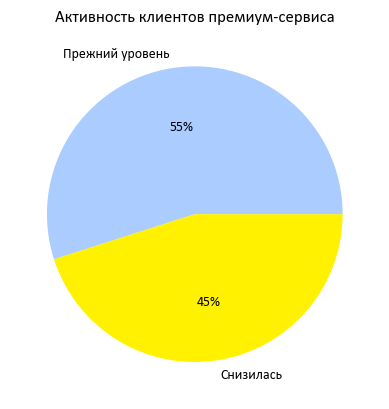

In [129]:
data = cust_full[cust_full['тип_сервиса'] == 'премиум']['покупательская_активность'].value_counts()
labels = ['Прежний уровень', 'Снизилась'] 
plt.title('Активность клиентов премиум-сервиса')
plt.pie(data, labels=labels, colors=('#aaccff', '#fff100'), autopct='%.0f%%')
plt.show()

Больше половины клиентов этого сегмента поддерживают прежний уровень активности, но у 45% она снизилась. Проанализируем, есть ли факторы, которые помогут поднять активность. 

#### Некоторые показатели в разрезе вероятности "оттока"

Возьмём данные по клиентам, чья активность снизилась, и построим несколько графиков, учитывающих предсказанные вероятности (<code>'target_pred'</code>, чем ближе к единице, тем вероятнее, что клиент уйдёт), в разрезах некоторых параметров (выбраны более-менее случайно из тех, которые полезно проверить). В таком визуализированном представлении нам будет легче заметить интересные закономерности. 

In [133]:
all_pred = np.round(pipe_final.predict_proba(X)[:, 1], 3)

In [134]:
X['target_init'] = y
X['target_pred'] = all_pred
X['общие_траты'] = X['мин1_мес_доход'] + X['мин2_мес_доход'] + cust_full['тек_мес_доход']

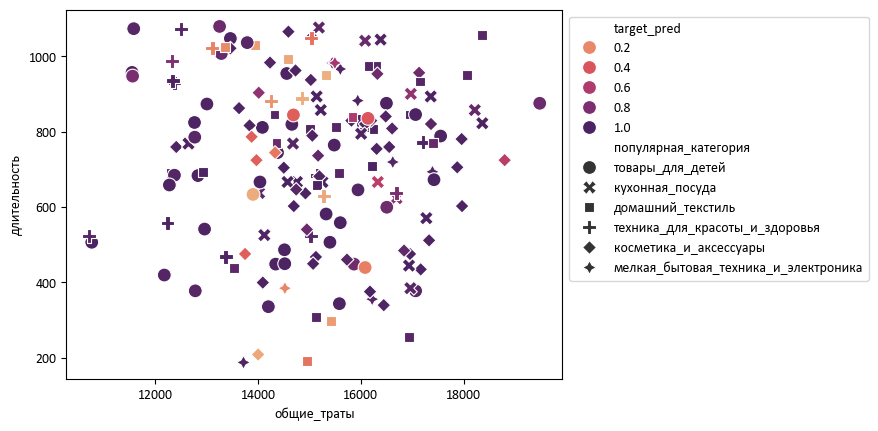

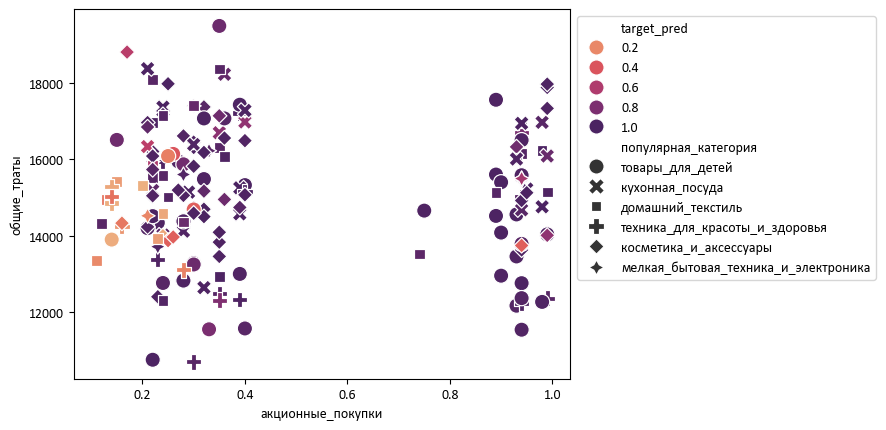

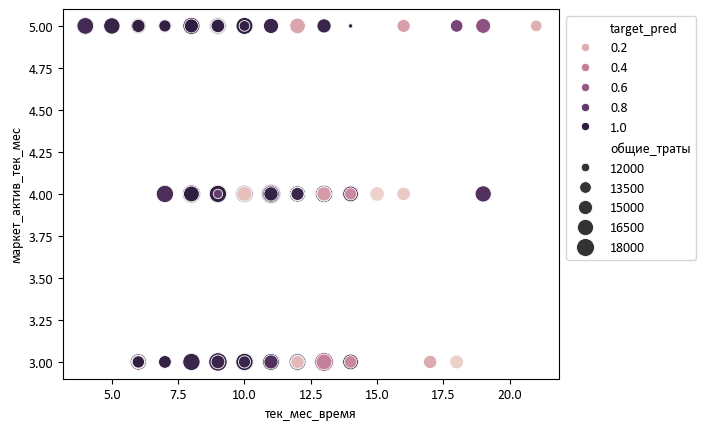

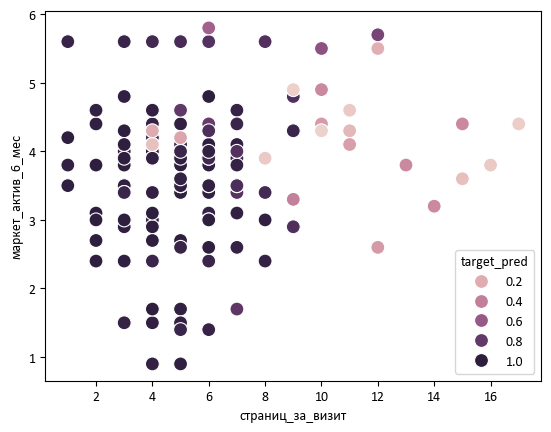

In [135]:
premium_decline = X[(X['тип_сервиса'] == 'премиум') & (X['target_init'] == 'снизилась')]

# chart 1 
ax = sns.scatterplot(premium_decline, hue='target_pred', y='длительность', x='общие_траты', 
                style='популярная_категория', palette='flare', s=100);
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# chart 2
ax = sns.scatterplot(premium_decline, hue='target_pred', y='общие_траты', x='акционные_покупки', palette='flare', s=120, style='популярная_категория');
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# chart 3
ax = sns.scatterplot(premium_decline, hue='target_pred', y='маркет_актив_тек_мес', x='тек_мес_время', size='общие_траты', sizes=(10, 200));
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# chart 4
sns.scatterplot(premium_decline, hue='target_pred', y='маркет_актив_6_мес', x='страниц_за_визит', s=100);
plt.show()


>Некоторые начальные наблюдения по параметрам клиентов, склонных к "уходу":
- страниц за визит - меньше 9;
- средне-полугодовые маркет. активности - меньше 2;
- активности на сайте в тек. месяце - меньше 10 минут;
- акционные покупки > 0.7. Здесь очень чёткая граница. Видимо, выделяются люди, которые покупают почти только по акциям;
- общие траты за 3 мес: меньше 13000, больше 17000.


#### Доход с пользователей, время на сайте

In [138]:
premium_active = cust_full[(cust_full['тип_сервиса'] == 'премиум') & (cust_full['покупательская_активность'] == 'прежний_уровень')]
premium_decline = cust_full[(cust_full['тип_сервиса'] == 'премиум') & (cust_full['покупательская_активность'] == 'снизилась')]

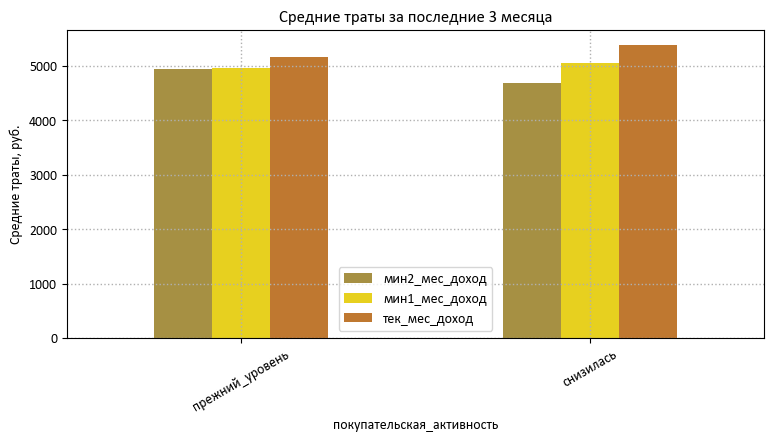

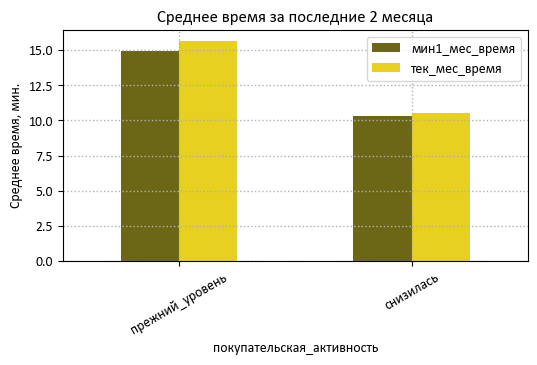

In [139]:
profit_cats = ['мин2_мес_доход', 'мин1_мес_доход', 'тек_мес_доход']
time_cats = ['мин1_мес_время', 'тек_мес_время']

cust_full[(cust_full['тип_сервиса'] == 'премиум')].groupby('покупательская_активность')[profit_cats].mean().plot(
    kind='bar', grid=True, color=('#A69043', '#e7d01f', '#BF7830'), figsize=(9, 4), ylabel='Средние траты, руб.',
    title='Средние траты за последние 3 месяца')
plt.grid(axis='both', linestyle='dotted', linewidth=1)
plt.xticks(rotation=30)

(cust_full[(cust_full['тип_сервиса'] == 'премиум')]
 .groupby('покупательская_активность')[time_cats].mean()
 .plot(
    kind='bar', grid=True, color=('#6C6716', '#e7d01f'), figsize=(6, 3), ylabel='Среднее время, мин.',
 title='Среднее время за последние 2 месяца')
)
plt.grid(axis='both', linestyle='dotted', linewidth=1)
plt.xticks(rotation=30)
plt.show()


Видим интересную картину - траты пользователей, активность которых мы считаем снижающейся, на самом деле возрастают за весь период (3 месяца) и превышают траты "стабильных" клиентов! Возможно, основной вклад вносят временные параметры, а не денежные? В таком случае нам в общем нет нужды беспокоиться о снижении "активности", по крайней мере, в этом сегменте пользователей. Ведь всё-таки для нас <b>важнее прибыль, а не то, сколько времени проводят на сайте покупатели</b>.

Рассчитаем дополнительный параметр - усреднённые траты пользователей на единицу времени пользования сайтом\приложением (можно назвать удельной доходностью сайта\приложения). Это позволит более точно характеризовать спад\подъём активности.

In [142]:
cust_full['мин1_удх'] = round((cust_full['мин1_мес_доход'] / cust_full['мин1_мес_время']), 1)
cust_full['тек_удх'] = round((cust_full['тек_мес_доход'] / cust_full['тек_мес_время']), 1)

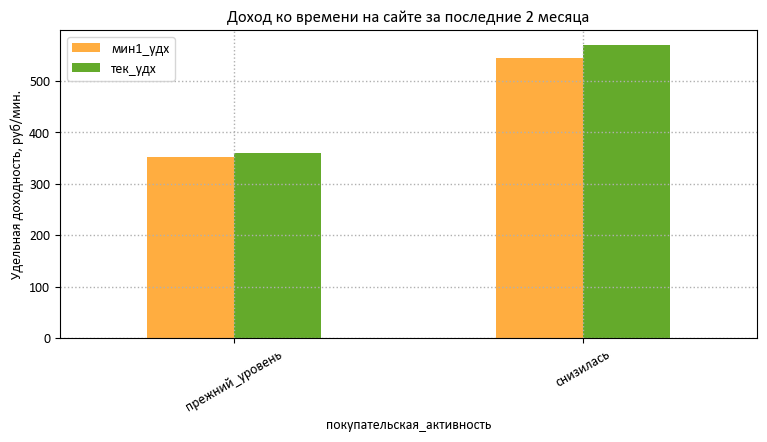

In [143]:
time_income_cats = ['мин1_удх', 'тек_удх']

cust_full[(cust_full['тип_сервиса'] == 'премиум')].groupby('покупательская_активность')[time_income_cats].mean().plot(
    kind='bar', grid=True, color=('#FFAD40', '#64AA2B'), figsize=(9, 4), ylabel='Удельная доходность, руб/мин.',
    title='Доход ко времени на сайте за последние 2 месяца')
plt.grid(axis='both', linestyle='dotted', linewidth=1)
plt.xticks(rotation=30)
plt.show()

Вот и подтверждение. Пользователи, отнесённые к "сниженной" категории, по факту тратят больше денег на единицу времени, то есть они либо используют сайт более эффективно, либо просто заходят за конкретными товарами.<br> В данном случае снижена не <i>покупательская</i> активность, а <i>активность на сайте</i>.

#### Разбивка пользователей по стажу на сайте

Теперь разделим клиентов на группы в зависимости от длительности пользования сайтом, и посмотрим на данные в разрезе стажа.<br>
Будем использовать 3 группы: до года, 1-2 года и больше двух лет.<br>
Можно подумать, что диапазоны слишком велики, по крайней мере, "новичковый" - он до года, а не 2-3 месяца. Но в выбранном для исследования "премиальном" сегменте <u>средний</u> стаж составляет 2 года (!), а минимальный - 4 месяца, поэтому такое разбиение оправданно.

In [147]:
labels = ['до_года', 'год_два', 'больше_2_лет']
bins = [0, 365, 730, 3000]
cust_full['кл_стаж'] = pd.cut(cust_full['длительность'], bins=bins, labels=labels)

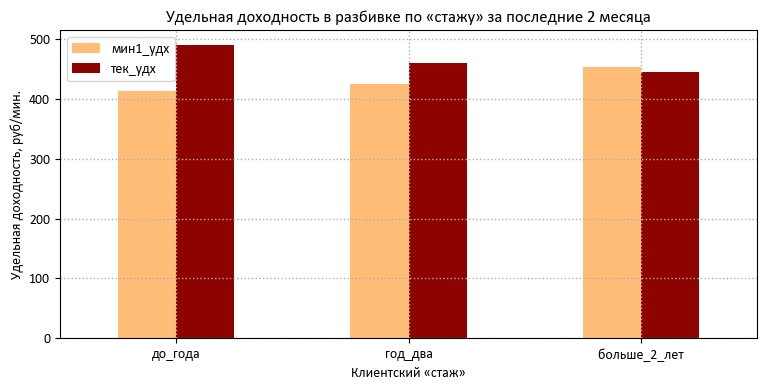

In [148]:
cust_full[(cust_full['тип_сервиса'] == 'премиум')].groupby(['кл_стаж'])[time_income_cats].mean().plot(
    kind='bar', grid=True, figsize=(9, 4), ylabel='Удельная доходность, руб/мин.', xlabel='Клиентский «стаж»',
    color=('#FFBD77', '#8D0300'),
    title='Удельная доходность в разбивке по «стажу» за последние 2 месяца')
plt.grid(axis='both', linestyle='dotted', linewidth=1)
plt.xticks(rotation=0)
plt.show()

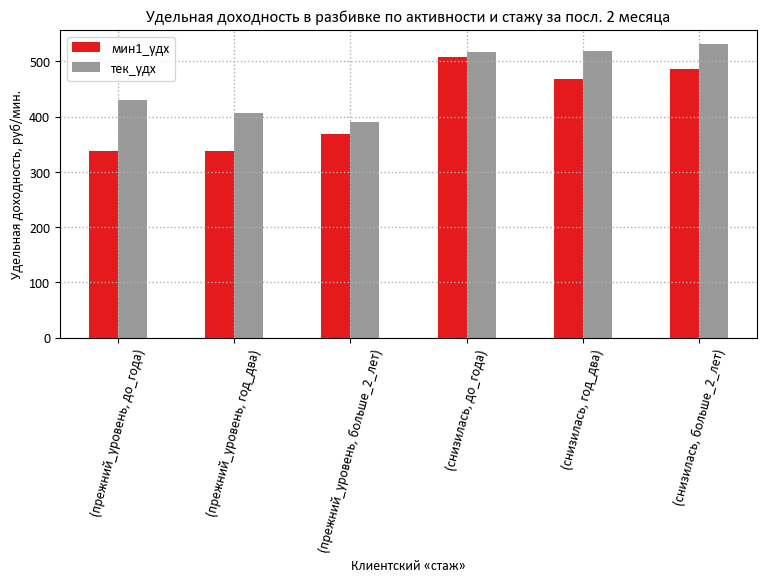

In [149]:
cust_full[(cust_full['тип_сервиса'] == 'стандарт')].groupby(['покупательская_активность', 'кл_стаж'])[time_income_cats].mean().plot(
    kind='bar', grid=True, figsize=(9, 4), ylabel='Удельная доходность, руб/мин.', xlabel='Клиентский «стаж»',
    cmap='Set1',
    title='Удельная доходность в разбивке по активности и стажу за посл. 2 месяца')
plt.grid(axis='both', linestyle='dotted', linewidth=1)
plt.xticks(rotation=75)
plt.show()

А вот это интересный инсайт. Чуть раньше мы определили, что в целом доходность от сайта (прибыль/время) растёт. При разбивке же по стажу видно, что всё чуть сложнее.<br> Удельная доходность в разбивке по группам стажа росла в прошлом месяце, но в текущем она падает, причём падает тем сильнее, чем больше стаж. <br>
Более детальный график показывает, что уд. доходность сильнее снижена у групп старше 1 года, отнесённых к "стабильным" клиентам. Стоит обратить на это внимание при планировании акций и рекламных кампаний.<br><br>
<b>N.B.</b> Было бы интересно узнать, а какова картина для сегмента "уровень сервиса = стандарт"? Мы проверили. Оказалось, что в общем та же - в текущем месяце удельная доходность от "стабильных" пользователей со стажем больше 1 года падает, а у "сбавляющих обороты" клиентов уд. доходность почти не зависит от стажа и <u>выше</u>. Мы проверили также разбиение на 4 временных отрезка по стажу (вместо трёх) - картина тренда <i>стаж 🡵 - доходность 🡶</i> становится лишь чётче.

#### Разбивка пользователей по общим тратам

Разобьём пользователей по общей потраченной за 3 месяца сумме и изучим некоторые особенности этих групп.<br>
Возьмём 4 интервала:
- сумма трат до 11 тыс. рублей,
- сумма трат от 11 до 14 тыс. рублей,
- сумма трат от 14 до 17 тыс. рублей,
- сумма трат выше 17 тыс. рублей.

In [153]:
labels = ['до_11000', '11-14000', '14-17000', 'больше_17000']
bins = [0, 11000, 14000, 17000, 30000]
cust_full['кл_ltv'] = cust_full[['мин2_мес_доход', 'мин1_мес_доход', 'тек_мес_доход']].sum(axis=1)

cust_full['кл_ltv_группа'] = pd.cut(cust_full['кл_ltv'], bins=bins, labels=labels)

- Узнаем процентное соотношение клиентов по группам трат в рассматриваемом нами сегменте "Премиум" и в сегменте "Стандарт".

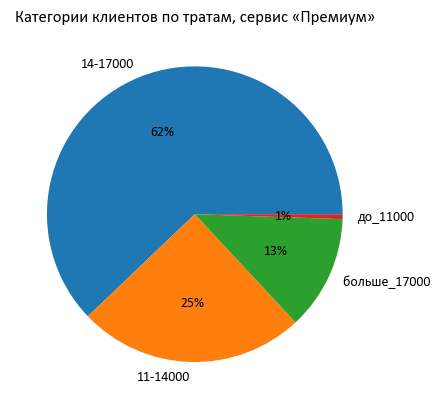

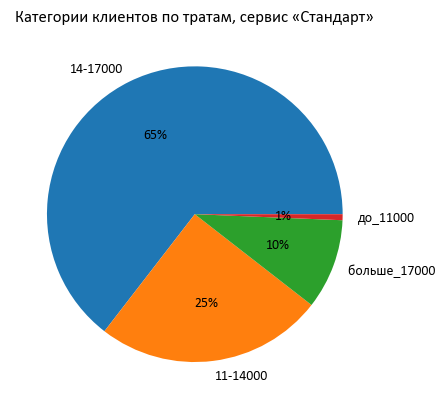

In [155]:
plt.title('Категории клиентов по тратам, сервис «Премиум»')
cust_full[cust_full['тип_сервиса'] == 'премиум']['кл_ltv_группа'].value_counts().plot(kind='pie', autopct='%.0f%%', ylabel='');
plt.show()

plt.title('Категории клиентов по тратам, сервис «Стандарт»')
cust_full[cust_full['тип_сервиса'] == 'стандарт']['кл_ltv_группа'].value_counts().plot(kind='pie', autopct='%.0f%%', ylabel='');
plt.show()

- Посмотрим, как распределяются популярные категории товаров по группам трат

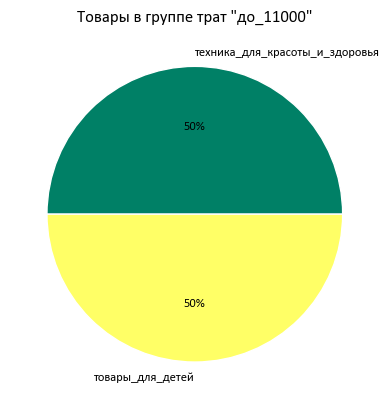

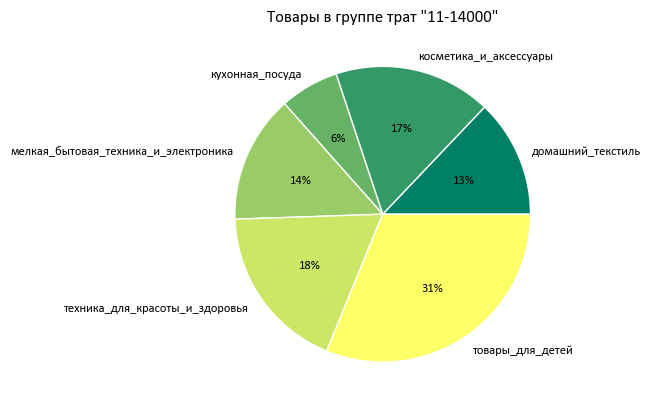

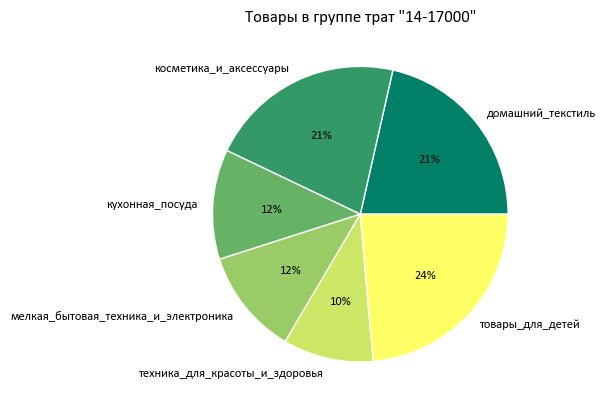

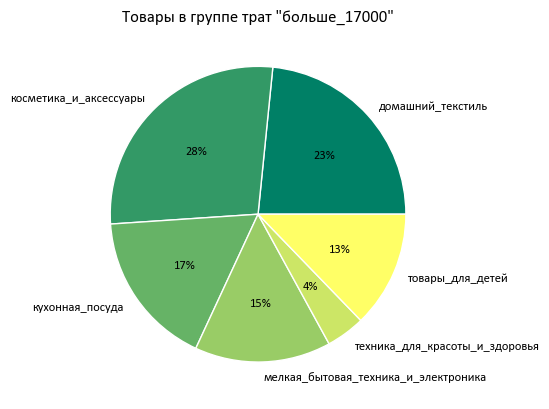

In [157]:
for ltv in labels:
    try:
        plt.title(f'Товары в группе трат "{ltv}"')
        (cust_full[(cust_full['тип_сервиса'] == 'премиум') & (cust_full['кл_ltv_группа'] == ltv)]
            .groupby('популярная_категория')['id'].count()
            .plot(kind='pie', autopct='%.0f%%', cmap='summer', textprops={"fontsize":9}, ylabel='', wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'})
        )
        plt.show()        
    except:
        print('Ошибка с группировкой или отображением')
        continue

#### Категории покупок пользователей

А какие товарные категории популярны в общем по сегменту? Покажем ниже.

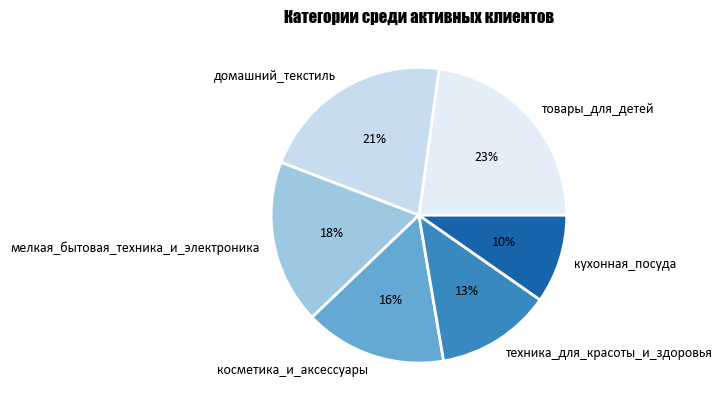

популярная_категория
товары_для_детей                        47
домашний_текстиль                       44
мелкая_бытовая_техника_и_электроника    37
косметика_и_аксесcуары                  32
техника_для_красоты_и_здоровья          26
кухонная_посуда                         20
Name: count, dtype: int64

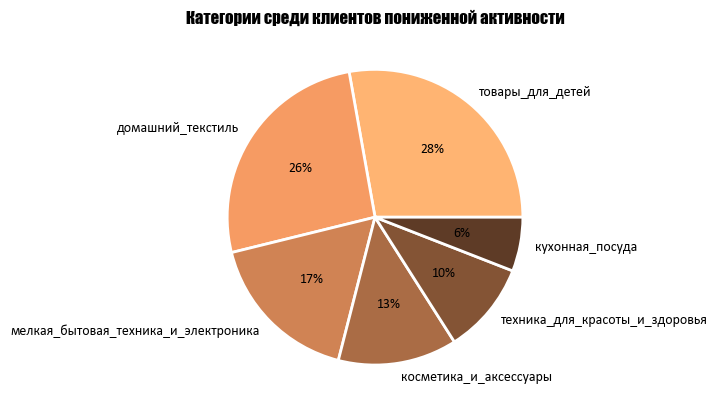

популярная_категория
косметика_и_аксесcуары                  47
товары_для_детей                        44
домашний_текстиль                       29
кухонная_посуда                         22
техника_для_красоты_и_здоровья          17
мелкая_бытовая_техника_и_электроника    10
Name: count, dtype: int64

In [160]:
plt.title('Категории среди активных клиентов', **({'fontname':TITLE_FONT}))
cmap = plt.get_cmap('Blues')
plt.pie(premium_active['популярная_категория'].value_counts(), autopct='%.0f%%', 
        labels=premium_active['популярная_категория'].value_counts().index, wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
        textprops={"fontsize":10},
        colors=list(cmap(np.linspace(0.1, 0.8, 6))))
plt.show()
display(premium_active['популярная_категория'].value_counts())

plt.title('Категории среди клиентов пониженной активности', **({'fontname':TITLE_FONT}))
cmap = plt.get_cmap('copper')
colors=list(cmap(np.linspace(0.9, 0.3, 6)))
plt.pie(premium_decline['популярная_категория'].value_counts(), autopct='%.0f%%', 
        labels=premium_active['популярная_категория'].value_counts().index, wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'}, 
        textprops={"fontsize":10}, colors=colors)
plt.show()
display(premium_decline['популярная_категория'].value_counts())

#### Выводы по анализу сегмента

<a id='cust_analysis'></a>

1. Важно оговорить, что для любого сегмента можно придумать и посчитать значительное количество метрик, вывести зависимости и соответствия между множеством групп\категорий\разбиений любого рода. В рамках проекта, будучи ограниченными во времени, мы привели некоторую часть этих показателей и указали, на что можно обратить внимание, в расчёте на то, что конкретные меры и идеи по удержанию активности клиентов будут предлагаться коммерческим отделом на основании нашего анализа.<br>
2. Для анализа был выбран сегмент клиентов с премиальным типом сервиса.<br>
Больше половины клиентов (55%) этого сегмента поддерживают прежний уровень активности, а у 45% она снизилась. Однако был открыт интересный факт: пользователи, отнесённые к "сниженной" категории, по факту тратят больше денег на единицу времени, то есть они либо используют сайт более эффективно, либо просто заходят за конкретными товарами. В данном случае снижена не покупательская активность, а активность на сайте.
<br><i>С другой стороны, такое противоречие заставляет задуматься о том, как конкретно определялось, снижается\стабильна ли активность клиента, и не содержатся ли ошибки в этой классификации в исходных данных.</i>

3. Удельная доходность в разбивке по группам пользовательского стажа (количество дней с момента регистрации) росла в прошлом месяце, но в текущем она падает, причём падает тем сильнее, чем больше стаж.
Конкретно, уд. доходность сильнее снижена у групп старше 1 года, отнесённых к "стабильным" клиентам. Стоит обратить на это внимание при планировании акций и рекламных кампаний.<br>

4. В сегменте больше людей в группе самыми высокими тратами (13% против 10% в "стандарте"), процент мало- и средне-тратящих такой же, как в "стандарте".<br><br>
В группах малых и средних трат (до 17000 руб. в сумме) самые популярные товары - <b>детские</b>. В группе высоких трат (больше 17000) это <b>косметика</b>. В группе с минимальными тратами слишком мало клиентов, популярные товары разбиты только на 2 категории, принимать эти данные в расчёты не стоит.<br><br>
5. В общем по сегменту среди "стабильных" клиентов наиболее популярны след. категории товаров: 
- товары для детей, домашний текстиль, мелкая бытовая техника и электроника.

Среди клиентов с падающей активностью, соответственно:
- товары для детей, домашний текстиль, мелкая бытовая техника и электроника (т. е. те же самые).
6. Шаги 4 и 5 помогут комм. отделу персонализировать предложения клиентам выбранного сегмента.

### Выводы по проекту

В этом проекте мы научились применять подбор моделей и гиперпараметров через пайплайны.<br><br>
Была проведена стандартная работа по предобработке датасетов и исследовательскому анализу.<br>
Подбор моделей осуществлялся через метод <b>GridSearch</b> с использованием пайплайнов для кодирования\масштабирования признаков и описания наборов гиперпараметров для тюнинга. Также мы попробовали метод добавления полиномиальных входных признаков для увеличения точности модели.<br>
Лучшей оказалась модель на базе опорных векторов <b>SVC (Support Vector Classifier)</b>.<br><br>
Для анализа важности признаков для предсказания модели мы использовали методы библиотеки <b>SHAP</b>, разобрались с не рассмотренным в теоретической части спринта выбором <b>explainer'а</b>, построили графики типа <b>beeswarm</b> и <b>waterfall</b>, наглядно иллюстрирующие влияние фичей как в целом, так и по отдельности.<br><br>
Наконец, мы выбрали произвольный сегмент пользователей сайта интернет-магазина (<b>клиенты с сервисом "премиум"</b>) и рассмотрели несколько зависимостей по данным внутри него, подготовив наглядные графики.
Детальные описания и выводы по анализу клиентов <a href='#cust_analysis'>см. здесь</a> (если ссылка не работает - это выводы страницей выше).

Важно отметить, что реальная польза от исследования ограниченна в связи с отсутствием данных, не использованных для обучения и предразмеченных по целевому признаку активности клиента, то есть на которых можно было бы применить выбранную нами модель. Также для полноценного анализа не хватает данных в динамике, для части параметров есть разбивка только на текущий, прошлый и позапрошлый месяцы.